# Autoencoder variacional
Autor: Leonardo Bravo

# Loading data

In [56]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import torchvision
from tqdm import tqdm_notebook
# CHANGE THIS PATH

path_to_datasets = '/home/leo/datasets'


mnist_train_data = torchvision.datasets.MNIST(path_to_datasets, train=True, download=True,
                                              transform=torchvision.transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST(path_to_datasets, train=False, download=True,
                                             transform=torchvision.transforms.ToTensor())

from torch.utils.data import DataLoader, SubsetRandomSampler
np.random.seed(0)
idx = list(range(len(mnist_train_data)))
np.random.shuffle(idx)
split = int(0.7*len(idx))

train_loader = DataLoader(mnist_train_data, batch_size=128, drop_last=True,
                          sampler=SubsetRandomSampler(idx[:split]))

test_loader = DataLoader(mnist_train_data, batch_size=128, drop_last=True,
                          sampler=SubsetRandomSampler(idx[split:]))

### Practical activity

Consider the MNIST dataset (torch dataset and dataloaders in the previous block)

1. Write a decoder network that recieves a latent vector and returns an MNIST digit
1. Write an encoder network that receives an MNIST digit and returns the parameters of the approximate posterior 
1. Write a Variational Autoencoder with Pyro
    1. Use a Bernoulli distribution for the likelihood of the generative model
    1. Use a Standard normal prior for the latent variable of the generative model
    1. Use a Normal distribution for the approximate poster
1. Train the model using the Mean Field ELBO

# Define model

In [102]:
from pyro.distributions import Bernoulli, Normal

# Write an encoder network that receives an MNIST digit and returns the parameters of the approximate posterior 
class Encoder(torch.nn.Module):
    def __init__(self, input_dim = 28*28, hidden_dim = 10, latent_dim = 2):
        super(Encoder, self).__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        # mean of likelihood
        self.z_loc = torch.nn.Linear(hidden_dim, latent_dim)
        
        # variance of likelihood
        self.z_scale = torch.nn.Linear(hidden_dim, latent_dim)
        self.activation = torch.nn.Softplus()
            
    def forward(self, x):
        # it receives an image
        # reshape?
        out = self.activation(self.hidden_1(x))
        out = self.activation(self.hidden_2(out))
        # get mean 
        z_loc = self.z_loc(out)
        # get variance
        z_scale = torch.exp(self.z_scale(out))
         # return meand variance
        return z_loc, z_scale
    
# Write a decoder network that recieves a latent vector and returns an MNIST digit
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim = 2, hidden_dim = 10, output_dim = 28*28):
        super(Decoder, self).__init__()
        self.hidden_1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden_2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.Softplus()
            
    def forward(self, z):
        # it receives the latent variable
        out = self.activation(self.hidden_1(z))
        out = self.activation(self.hidden_2(out))
        
        out = self.activation(self.output(out))
        # it returns the MNIST digit
        return out
    
class VariationalAutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim = 2):
        super(VariationalAutoEncoder, self).__init__() 
        self.encoder = Encoder(latent_dim = latent_dim)
        self.decoder = Decoder(latent_dim = latent_dim)
        self.latent_dim = latent_dim
        
    # generative model
    # p(x) = integral p(x|z) p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", size=x.shape[0]):
            # p(z) (prior)
            z_loc = torch.zeros(x.shape[0], self.latent_dim)
            z_scale = torch.ones(x.shape[0], self.latent_dim)
            z = pyro.sample("latent", Normal(z_loc, z_scale).to_event(1))
            
            # compute pi
            pi = self.decoder(z)
            
            # compute likelihood p(x|z)
            pyro.sample("reconstruction", Bernoulli(logits = pi, validate_args=False).to_event(1), 
                        obs = x.reshape(-1, 28*28))
            
    # posterior approximate
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", size=x.shape[0]):
            # q(z|x)
            z_loc, z_scale  = self.encoder.forward(x.reshape(-1, 28*28))
            pyro.sample("latent", Normal(z_loc, z_scale).to_event(1))

# Define SVI 

In [106]:
pyro.enable_validation(True)
pyro.clear_param_store()

vae = VariationalAutoEncoder()
svi = pyro.infer.SVI(model=vae.model, 
                     guide=vae.guide, 
                     optim=pyro.optim.Adam({"lr": 1e-2}), 
                     loss=pyro.infer.TraceMeanField_ELBO(), 
                     num_samples=100)

# Train model

<IPython.core.display.Javascript object>


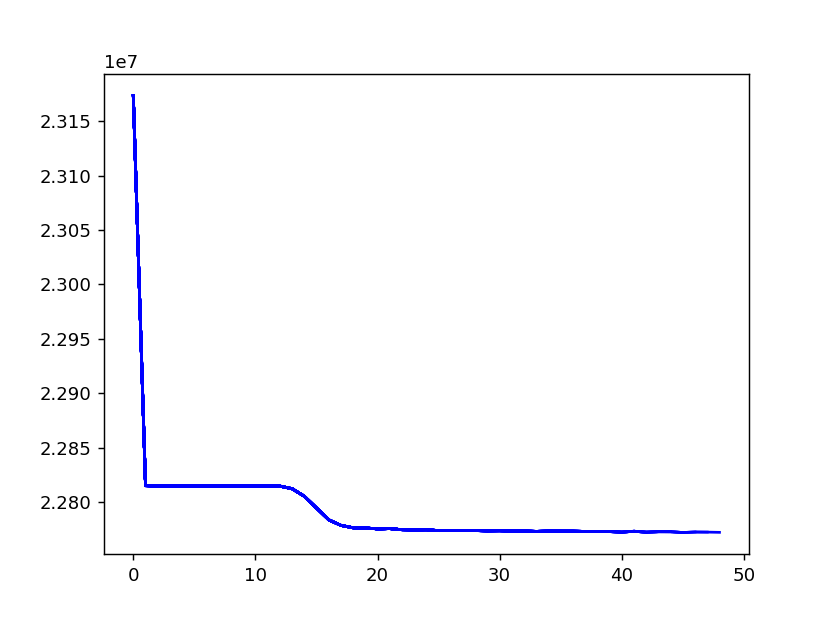

In [107]:
# Train the model using the Mean Field ELBO

fig, ax = plt.subplots()
epochs = 50
epochs_loss_array = np.zeros((epochs, 2))
for nepoch in tqdm_notebook(range(epochs)):
    
    # Actual training
    epoch_loss_train = 0.0
    for x, label in train_loader:
        epoch_loss_train += svi.step(x)
    epochs_loss_array[nepoch, 0] = epoch_loss_train
    
#     # validation data
#     epoch_loss_test = 0.0
#     for x, label in test_loader:
#         epoch_loss_test += svi.step(x)
#     epochs_loss_array[nepoch, 1] = epoch_loss_test
    
    # ploting results
    ax.plot(epochs_loss_array[0:nepoch, 0], c="b", label = "train")
#     ax.plot(epochs_loss_array[0:nepoch, 1], c="r", label = "test")
    fig.canvas.draw()

Se observa que pérdida disminuye con el número de epochs, y que luego del epoch 20, la pendiente ya no cambia de forma considerable, mantiendose similar en estos epochs.

# Displaying some reconstructions

<IPython.core.display.Javascript object>


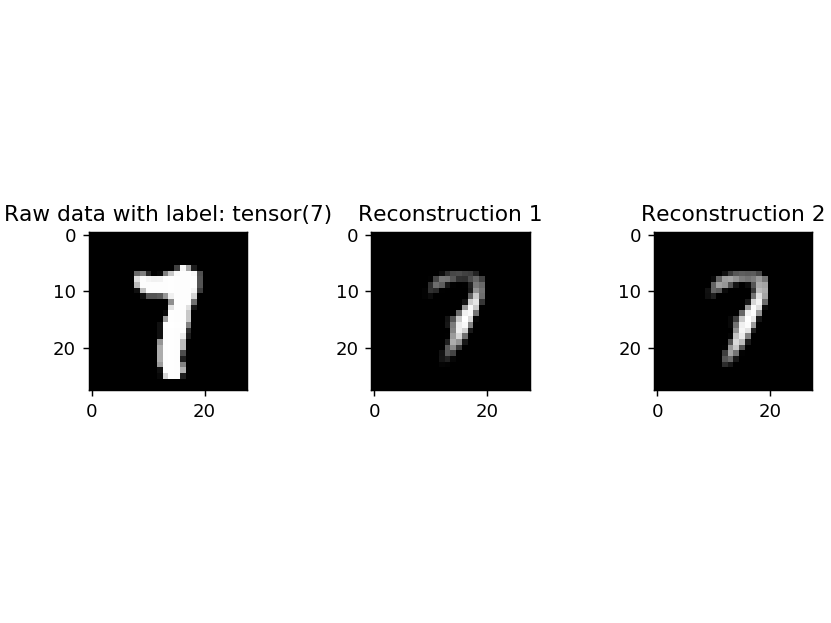

(1, 28, 28)
(1, 28, 28)


In [138]:
# Reconstructions
x, label = next(iter(test_loader))

x_one = x[0, :, :]
# print(x_one.shape)
label_one = label[0]
# print(label_one)
z_loc, z_scale = vae.encoder.forward(x_one.reshape(-1, 28*28))

fig, ax = plt.subplots(1, 3, tight_layout = True)

ax[0].set_title("Raw data with label: " + str(label_one))
ax[0].imshow(x_one[0, :, :], cmap=plt.cm.Greys_r)

output_activation = torch.nn.Sigmoid()

# get samplings
for i in range(1, 3):
    
    # sampling from posteior 
    z = Normal(z_loc, z_scale).rsample()
#     print(z)

    reconstruction = output_activation(vae.decoder(z)).reshape(-1, 28, 28). detach().numpy()
    print(reconstruction.shape)
    # reconstruction
    ax[i].set_title("Reconstruction "+ str(i))
    ax[i].imshow(reconstruction[0, :, :], cmap=plt.cm.Greys_r)

Se observa que ambas reconstrucciones son diferentes a pesar de provenir del mismo input (raw data). Esto se debe a que desde el input se obtienen parámetros para la distribución que genera los datos. Estos parámetros se utilizan para definir la distribución generadora de datos (posterior (p(z|x)). Por lo que cada imágen reconstruida se obtiene desde variables latentes muestreadas desde la misma distribucioń. Este comportamiento es diferentes al Autoencoder tradicional, ya que en este ultimo, las varaiables latentes son determinastas, mientras que en AEV, las variables latentes son estocásticas, por lo que tiene una distribución generadora.

# 2D visualization of latent variables

z shape:  torch.Size([128, 2])


<IPython.core.display.Javascript object>


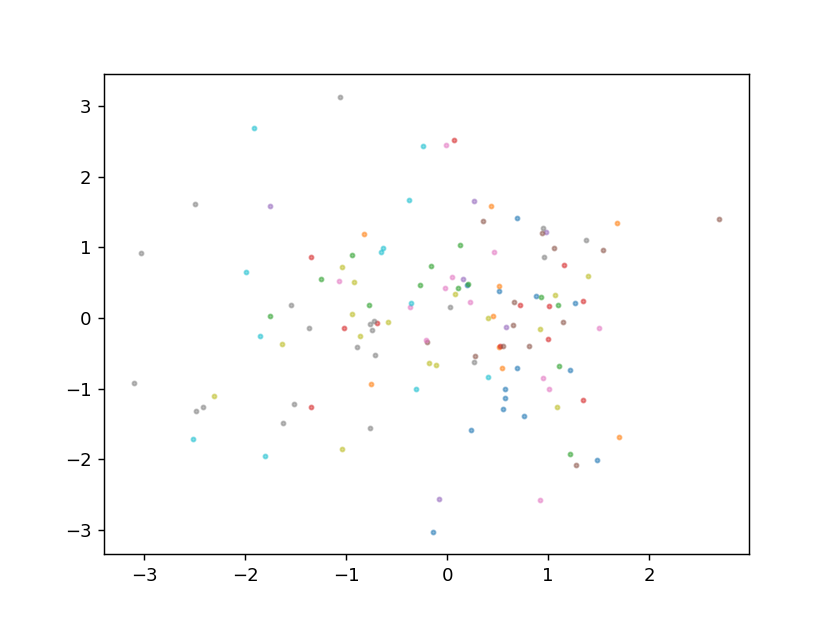

In [149]:
# 2D Visualization 

# get data
x, label = next(iter(test_loader))

# get posterior parameters 
z_loc, z_scale = vae.encoder.forward(x.reshape(-1, 28*28))

# get latent variables from posterior (normal distribution)
z = Normal(z_loc, z_scale).rsample()
print("z shape: ", z.shape)

# plot
fig, ax = plt.subplots()
for digit in range(10):
    
    # create mask of digit
    mask = label.detach().numpy() == digit
    # plot class
    ax.scatter(z[mask, 0].detach().numpy(), z[mask, 1].detach().numpy(), 
               s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(digit))

Se observan como se distribuyen los datos para las 2 dimensiones de las variables latentes.

# Main conclusions
Lo mas relevante del modelo, es que las variables latentes corresponden a variables estocásticas, teniendose una distribución para estas. Esto permite tener un modelo generativo, desde el cual se pueden obtener variables latentes (obtenidas desde distirbución) y por lo tanto, reconstrucciones de data original (data augmentation).
Otro aspecto relevante corresponde a la suposición de las distirbuciones de variables latentes (normalidad). Esto podría ser interesante espcialmente para el trabajo de tesis, ya que se podrían analizar diferentes distribuciones (Desconozco si es posible).